# This is the driver program for the ARIMA process. 

- It starts with testing stationarity.
- Then it runs a grid search for the best parameters. It returns the best parameters and we use those going forward.
- Then we summarize residual errors for the model.
- Then we summarize residual errors from bias corrected forecasts.
- Plots test vs prediction scores
- Saves finalized model to file
- Loads the finalized model and makes a prediction. This proves that it works.
- Then finally we forecast for the balance of the year.

## Update the John Hopkins, Covid-19 data 
https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. 

In [37]:
# import libraries

# local function calls
import arima_grid_search as ags
import load_data as ld
import multi_step_forecast as msf
import stationarity as st
import summarize
import test_prediction_save_forecast_1day as tpsf1

# Standard libararies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

## Prepare arguments for driver

In [38]:
arg_dict = {'file_name_1': r'data\all_df.csv',
            'file_name_2': r'C:\Users\Lindsay Moir\OneDrive\Documents\GitHub\covid\data\country_codes_edited.csv',
            'feature': 'Alpha_3',
            'place': 'USA',
            'dependent_variable': 'Deaths',
            'path': r'C:\Users\Lindsay Moir\OneDrive\Documents\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports',
            'best_cfg': (7,2,2), 
            'order_list': [],
            'p_values': range(6,11),
            'd_values': range(1,3),
            'q_values': range(1,3),
            'split_value': .5,
            'bias': 0, # First time thru bias is 0
            'date': '06-30-2021'}

## Load John Hopkins data

The "data date" is 2021-01-27 00:00:00

ADF Statistic: -1.183459
p-value: 0.680670
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


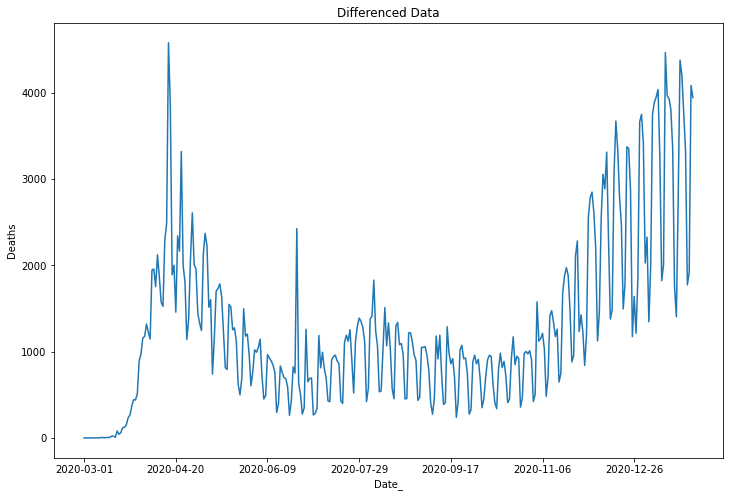

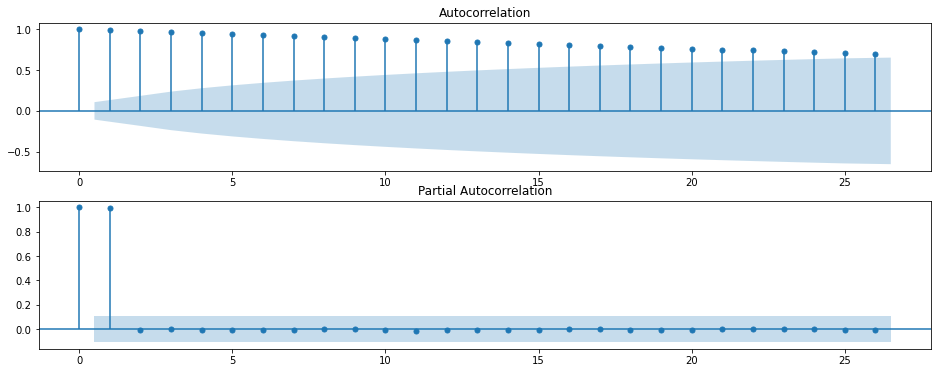

RMSE is 389.757 with ARIMA of (6, 2, 1)
RMSE is 381.655 with ARIMA of (8, 2, 1)
RMSE is 381.073 with ARIMA of (9, 2, 1)
RMSE is 384.702 with ARIMA of (10, 2, 1)
RMSE is 377.317 with ARIMA of (10, 2, 2)

Best RMSE Score is 377.317 with ARIMA of (10, 2, 2)

RMSE: 377.317
       Residual Statistics
count           167.000000
mean             31.597457
std             377.122483
min           -1507.692209
25%            -170.523994
50%              -1.087216
75%             183.249658
max            1288.100654


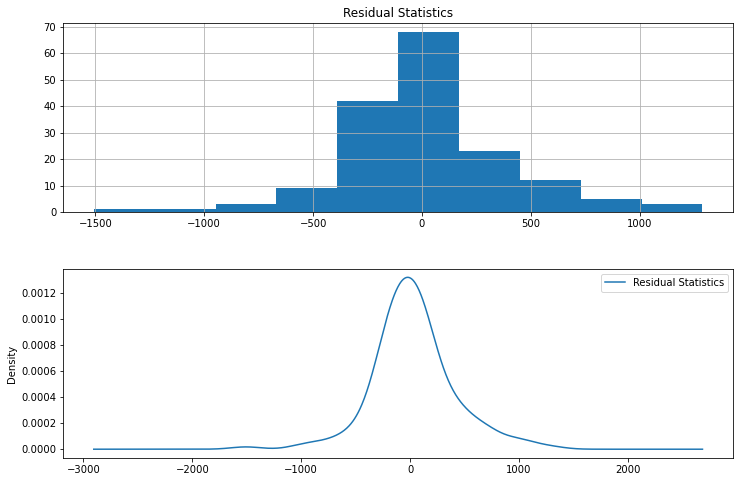


bias IS saved in arg_dict["bias"] for subsequent run is: 31.597457131975634 


RMSE: 375.992
       Residual Statistics
count         1.670000e+02
mean          4.705410e-12
std           3.771225e+02
min          -1.539290e+03
25%          -2.021215e+02
50%          -3.268467e+01
75%           1.516522e+02
max           1.256503e+03


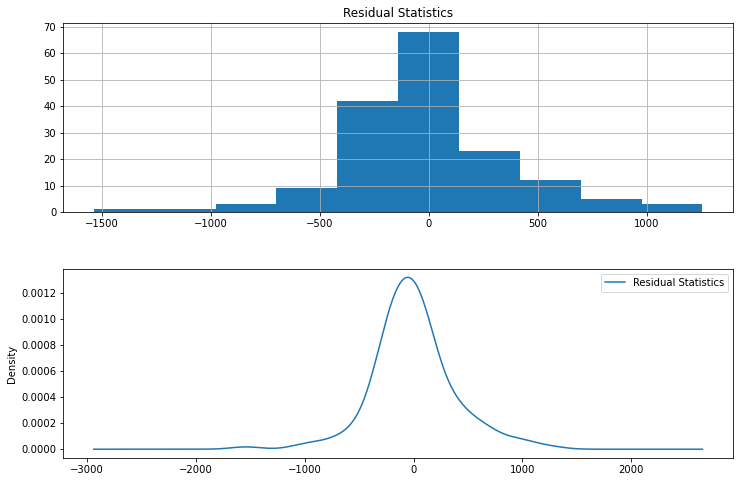


bias NOT saved in arg_dict["bias"] for subsequent run is: 4.7054097145617364e-12 



In [39]:
df, li_set = ld.driver(arg_dict)

# Get the date of the last file to establish the currency of the data.
print(f'The "data date" is {df["Date_"].iloc[-1]}\n')

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test for stationarity
df = st.driver(arg_dict)

# save df for subsequent independent processing
df.to_csv('df.csv')
      
# Grid search ARIMA parameters 
order_list = ags.driver(df, arg_dict)
arg_dict.update({'order_list': order_list})
arg_dict.update({'best_cfg': order_list[0]})

# summarize residual errors for an ARIMA model and return bias
model_fit, test, predictions = summarize.driver(df, arg_dict)

# Rerun summarize, as bias adjusted
model_fit, test, predictions = summarize.driver(df, arg_dict)
arg_dict.update({'test': test, 'predictions': predictions, 'model_fit': model_fit})

# save arg_dict for subsequent independent processing
with open('arg_dict.pickle', 'wb') as handle:
    pickle.dump(arg_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Plot test (actual) vs predictions, save, and forecast

The predicted cumulative Deaths for USA for tomorrow (input data plus 1 day) are 430,021


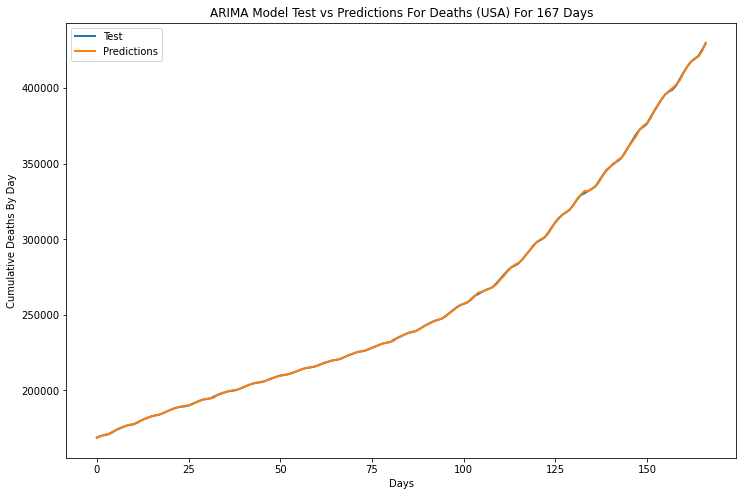

In [40]:
tpsf1.driver(arg_dict)

NB The above prediction of a single day in the future will only rarely match the the first day in the multi step forecast below. The reason is that the ARIMA model is a moving average model. The specific days included in the moving average change in the multi step forecast. 

## Multi Step Forecast

The USA prediction is for 1,063,817 cumulative Deaths to occur by 2021-06-30 00:00:00


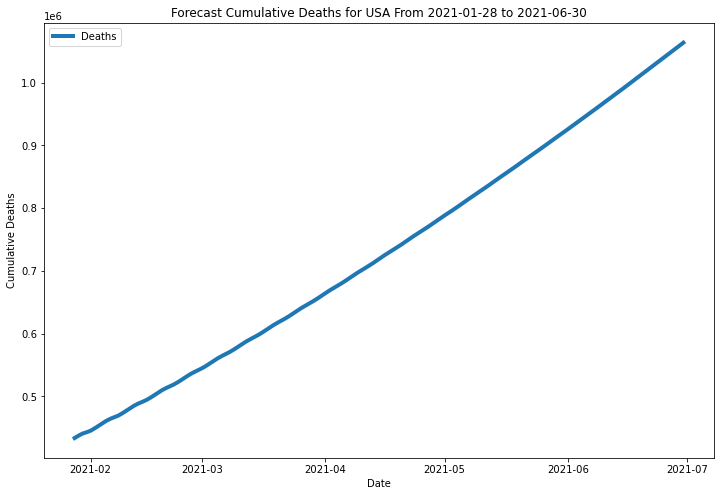

In [41]:
df.index = pd.to_datetime(df.index)
forecast_df = msf.driver(df, arg_dict)

## Actual
If the arg_dict has a prediction date later than the above date, the reason is that ARIMA expects the jurisdiction to have no more instances by the date indicated. We truncate the prediction at that point. 

In [42]:
new_col = "Daily_" + arg_dict['dependent_variable']
df[new_col] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
print('Actual')
df.head(14) 

Actual


,Deaths,Daily_Deaths
Date_,,
2020-02-29,1.0,NaN
2020-03-01,1.0,0.0
2020-03-02,6.0,5.0
2020-03-03,7.0,1.0
2020-03-04,11.0,4.0
2020-03-05,12.0,1.0
2020-03-06,14.0,2.0
2020-03-07,17.0,3.0
2020-03-08,21.0,4.0


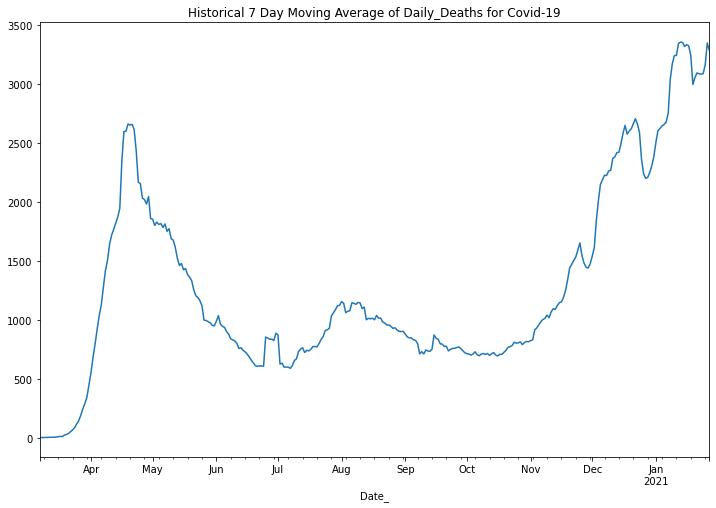

In [43]:
# Graph a 7 day rolling average rate
df['moving_average'] = df[new_col].rolling(7).mean()
df.dropna(inplace=True)
df['moving_average'] = df['moving_average'].astype(np.int)
title = arg_dict['place'] + ' Historical 7 Day Moving Average of ' + new_col + ' for Covid-19'
plt.title(title)
df['moving_average'].plot();

## 14 Day Forecast

In [44]:
forecast_df[new_col] = forecast_df[arg_dict['dependent_variable']] - forecast_df[arg_dict['dependent_variable']].shift()
forecast_df.iloc[0,1] = forecast_df.iloc[0,0] - df.iloc[-1,0]
print('Predicted')
forecast_df.head(14)

Predicted


,Deaths,Daily_Deaths
Date_,,
2021-01-28,433429.0,4234.0
2021-01-29,437279.0,3850.0
2021-01-30,440560.0,3281.0
2021-01-31,442642.0,2082.0
2021-02-01,445062.0,2420.0
2021-02-02,448775.0,3713.0
2021-02-03,452920.0,4145.0
2021-02-04,457048.0,4128.0
2021-02-05,461006.0,3958.0


## Conclusions

- The code is quite flexible. It accepts any feature and will predict the values based on it. 

## Limitations

ARIMA is very sensitive to the most recent data. This is a feature of ARIMA models. This is probably not the best for long term predictions. However, it is also probably the best that we can do right now.